In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

import copy
import os
import sys
import time

In [2]:
writer = SummaryWriter(log_dir='resnet18_runs')

In [3]:
data_dir = './data'
batch_size = 128
epoch = 25
start_epoch = 0
input_size = 224

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=0) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

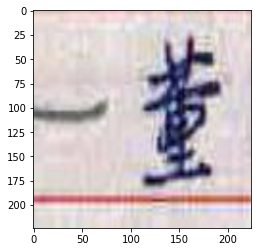

Label: 董


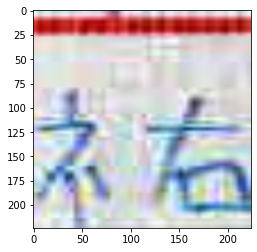

Label: 祐


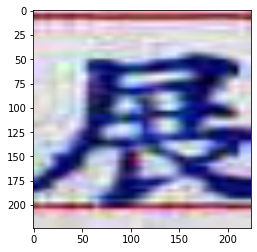

Label: 展


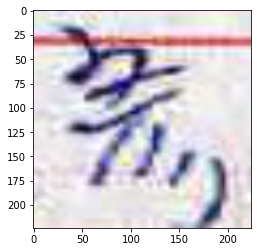

Label: 彥


In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

'''
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
'''

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

for i in range(4):
    imshow(inputs[i])
    print(f'Label: {class_names[classes[i]]}')

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            time_elapsed = time.time() - since
            print(f'{phase} Loss: {epoch_loss: .4f} Acc: {epoch_acc: .4f}')
            
            if phase == 'train':
                train_loss = epoch_loss
                train_acc = epoch_acc
                
            else:
                val_loss = epoch_loss
                val_acc = epoch_acc
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': train_acc, 'val': val_acc}, epoch)
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60: .0f}m {time_elapsed % 60: .0f}s')
    print(f'Best val Acc: {best_acc: 4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    writer.close()
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                '''
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                '''
                print(f'Label: {class_names[labels[j]]} Predict: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=epoch)

  0%|          | 0/431 [00:00<?, ?it/s]

Epoch 1/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  6.6878 Acc:  0.0034


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  6.5278 Acc:  0.0079

Epoch 2/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  6.2476 Acc:  0.0291


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  6.0050 Acc:  0.0456

Epoch 3/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  5.6747 Acc:  0.0928


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  5.3884 Acc:  0.1151

Epoch 4/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  5.0985 Acc:  0.1924


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  4.8695 Acc:  0.2203

Epoch 5/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  4.5284 Acc:  0.3086


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  4.2922 Acc:  0.3350

Epoch 6/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  3.9732 Acc:  0.4184


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  3.7515 Acc:  0.4416

Epoch 7/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  3.4532 Acc:  0.5148


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  3.2685 Acc:  0.5255

Epoch 8/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  3.1500 Acc:  0.5751


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  3.2136 Acc:  0.5384

Epoch 9/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  3.0980 Acc:  0.5850


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  3.1648 Acc:  0.5430

Epoch 10/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  3.0518 Acc:  0.5932


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  3.0909 Acc:  0.5502

Epoch 11/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  3.0062 Acc:  0.6020


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  3.0562 Acc:  0.5603

Epoch 12/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  2.9618 Acc:  0.6078


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  3.0322 Acc:  0.5680

Epoch 13/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  2.9174 Acc:  0.6147


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  2.9816 Acc:  0.5751

Epoch 14/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  2.8751 Acc:  0.6210


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  2.9261 Acc:  0.5815

Epoch 15/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  2.8456 Acc:  0.6259


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  2.9290 Acc:  0.5786

Epoch 16/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  2.8422 Acc:  0.6264


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  2.9463 Acc:  0.5821

Epoch 17/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  2.8366 Acc:  0.6288


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  2.9486 Acc:  0.5843

Epoch 18/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  2.8323 Acc:  0.6283


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  2.9540 Acc:  0.5825

Epoch 19/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  2.8285 Acc:  0.6292


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  2.9289 Acc:  0.5794

Epoch 20/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  2.8256 Acc:  0.6286


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  2.9399 Acc:  0.5839

Epoch 21/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  2.8211 Acc:  0.6306


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  2.9298 Acc:  0.5831

Epoch 22/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  2.8183 Acc:  0.6318


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  2.9450 Acc:  0.5843

Epoch 23/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  2.8182 Acc:  0.6317


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  2.9130 Acc:  0.5823

Epoch 24/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  2.8169 Acc:  0.6312


  0%|          | 0/431 [00:00<?, ?it/s]

val Loss:  2.9365 Acc:  0.5847

Epoch 25/25
----------


  0%|          | 0/108 [00:00<?, ?it/s]

train Loss:  2.8160 Acc:  0.6308


100%|██████████| 108/108 [00:30<00:00,  3.54it/s]

val Loss:  2.9024 Acc:  0.5840

Training complete in  92m  7s
Best val Acc:  0.584738


Label: 宣 Predict: 宜


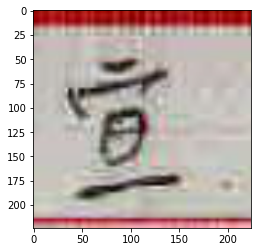

Label: 行 Predict: 妤


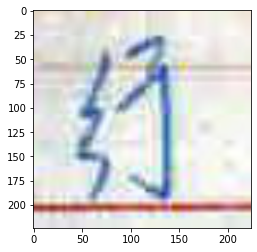

Label: 開 Predict: 開


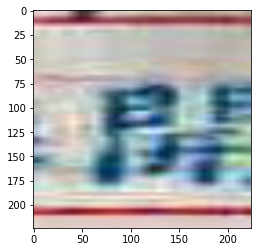

Label: 倫 Predict: 倫


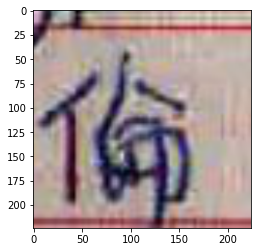

Label: 山 Predict: 山


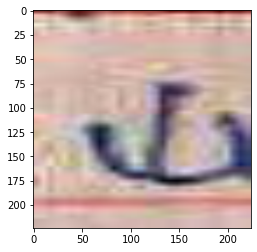

Label: 動 Predict: 動


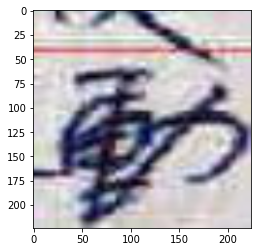

In [10]:
visualize_model(model_ft)